In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from experiment_utils import *



In [8]:
def metric_has_substring(metric, substrings):
    for sub in substrings:
        if sub in metric:
            return True
    return False

File 'results\hyperparams_race.csv' successfully loaded as DataFrame.
['Compas Dataset', 'Adult Dataset']
['MLPClassifier', 'LogisticRegression']
["['race']"]
['FairMask Bias Mitigation', 'No Bias Mitigation', 'FYP VAE', 'Reweighing Bias Mitigation', 'FairBalance Bias Mitigation', 'LFR']
['{}', '{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1451, latent_dim=12, mask_values=None vae_layers=(100, 75, 50), lr=0.022400000000000003, \\nlosses_used=[\'Flipped ADV loss\', \'Pos Y vec loss\', \'Reconstruction loss\', \'KL divergence loss\'])Flipped ADV loss: {\'weight\': 0.0072, \'lr\': 0.063, \'optimizer\': \'Adam\', \'layers\': (75, 30, 10), \'input_dim\': 10, \'sens_col_ids\': [8]}, Pos Y vec loss: {\'weight\': 1548000.0}, Reconstruction loss: {\'weight\': 20.85}, KL divergence loss: {\'weight\': 0.004}"}', '{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1573, latent_dim=8, mask_values=None vae_layers=(128, 32), lr=0.0049, \\nlosses_used=[\'Sensitive KL loss\', \'

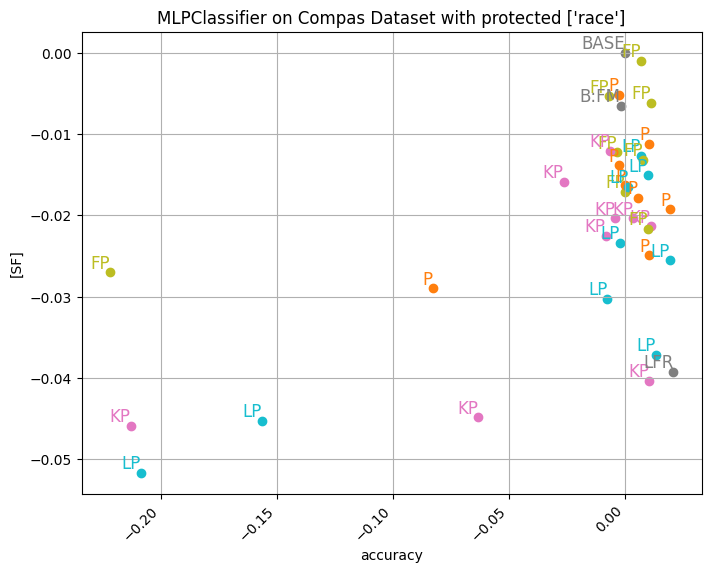

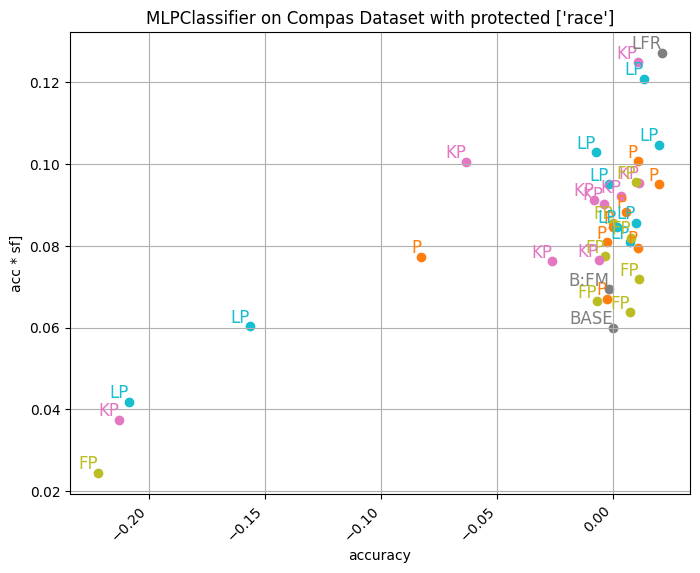

____________________________________________________________________________________________________
Compas Dataset , LogisticRegression ['race']
unable to find base for 120 index 0 is out of bounds for axis 0 with size 0


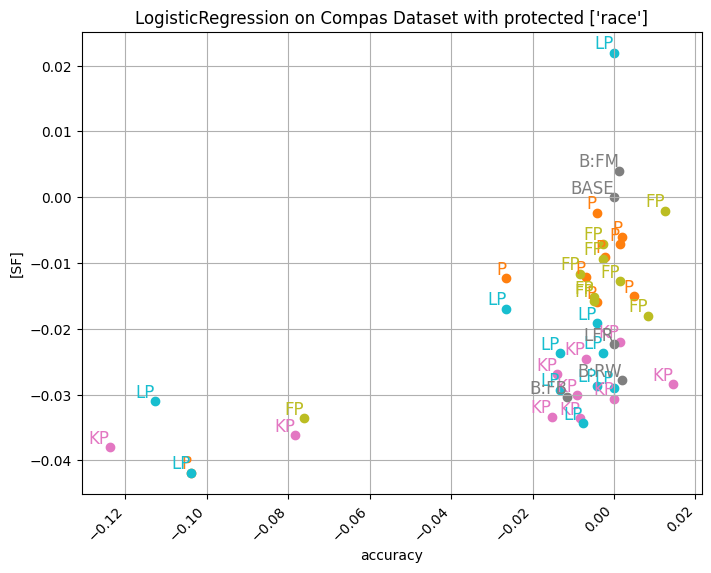

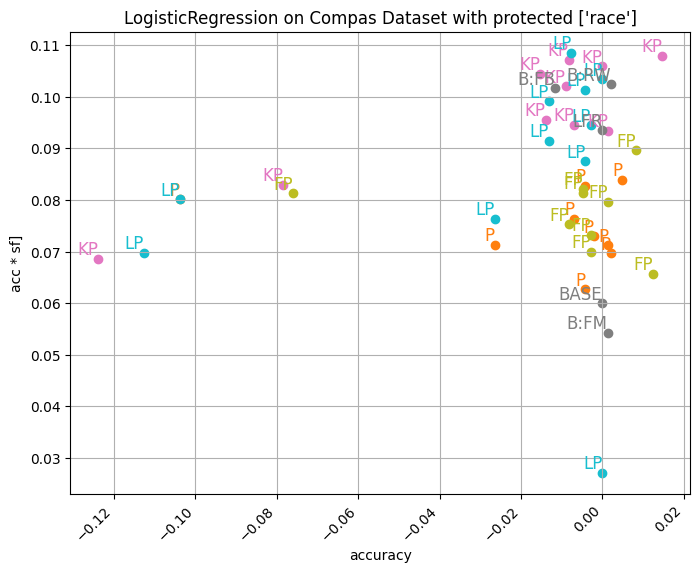

____________________________________________________________________________________________________
Adult Dataset , MLPClassifier ['race']


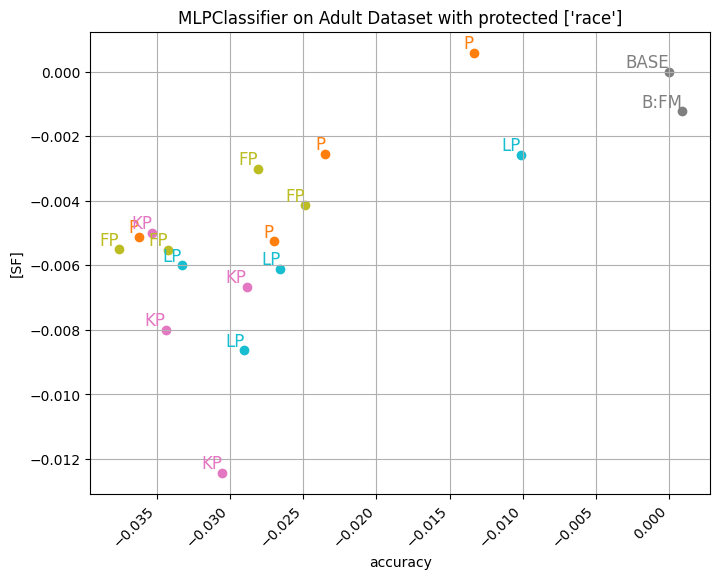

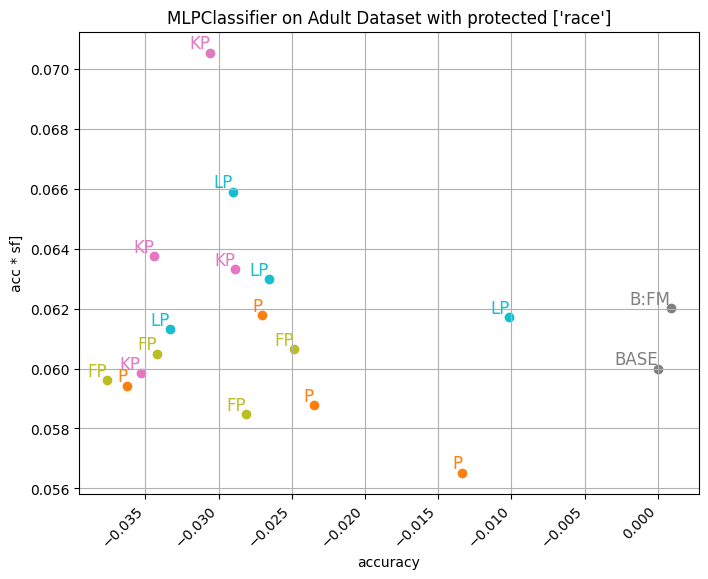

____________________________________________________________________________________________________
Adult Dataset , LogisticRegression ['race']


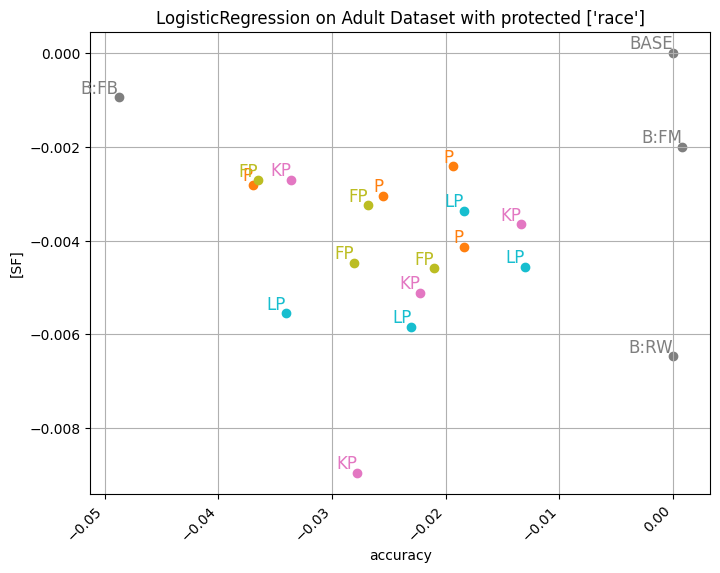

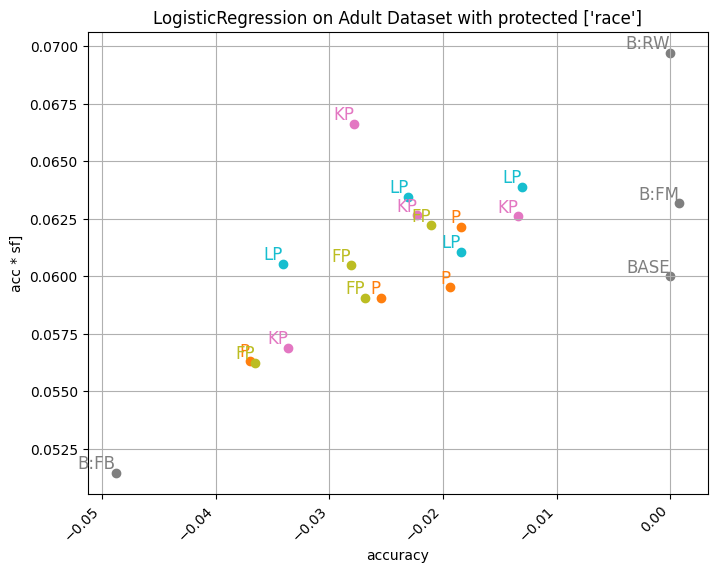

In [9]:
results_filename = "hyperparams_race"

results_file = os.path.join("results",results_filename +".csv")
reader = ResultsReader(results_file)

all_metrics = reader.metrics
metrics_to_use = ["SF"]
metrics_to_display = [m for m in all_metrics if metric_has_substring(m, metrics_to_use)]

for col in ResultsReader.FILTERABLE:
    print(reader.get_all_column_values(col))
    
#ffvae_reader.clear_filters()


grapher = ResultsGrapher(reader)
grapher.show_legend = False
grapher.plot_metrics_vs_metric(mean=True, relative=True, metrics = metrics_to_display+[OtherColReader.ACC_SF_TO])

reader.clear_filters()



File 'results\hyperparams_sex.csv' successfully loaded as DataFrame.
['Compas Dataset', 'German Dataset', 'Adult Dataset']
['MLPClassifier', 'LogisticRegression']
["['sex']"]
['FYP VAE', 'Reweighing Bias Mitigation', 'FairBalance Bias Mitigation', 'FairMask Bias Mitigation', 'No Bias Mitigation', 'LFR']
['{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1052, latent_dim=12, mask_values=None vae_layers=(50, 45, 35, 30), lr=0.011619999999999998, \\nlosses_used=[\'Latent sens ADV loss\', \'Pos Y vec loss\', \'Reconstruction loss\', \'KL divergence loss\'])Latent sens ADV loss: {\'weight\': 0.07150000000000001, \'lr\': 0.051500000000000004, \'optimizer\': \'Adam\', \'layers\': (75, 30, 10), \'input_dim\': 11}, Pos Y vec loss: {\'weight\': 1572000.0}, Reconstruction loss: {\'weight\': 21.6}, KL divergence loss: {\'weight\': 0.0053}"}', '{}', '{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1491, latent_dim=7, mask_values=None vae_layers=(100, 100, 30), lr=0.01848, \\n

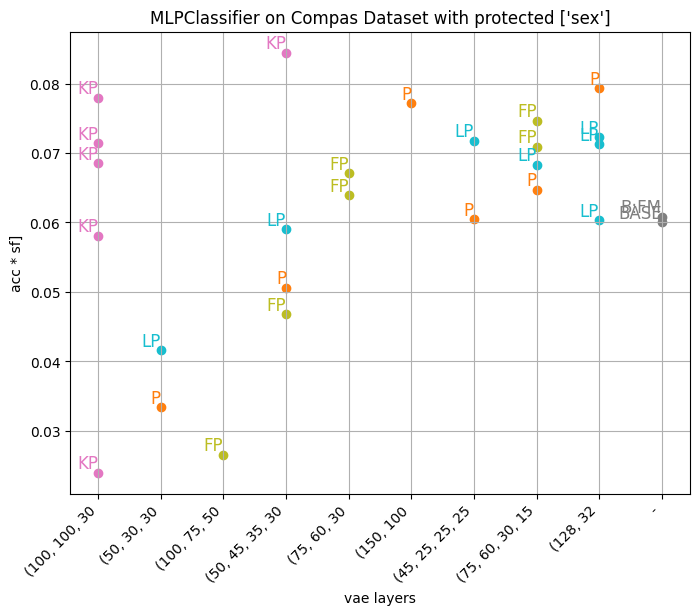

____________________________________________________________________________________________________
Compas Dataset , LogisticRegression ['sex']


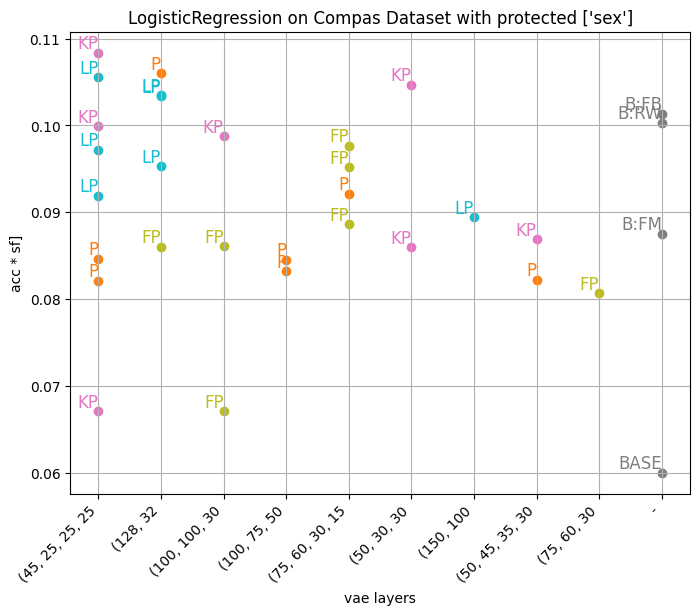

____________________________________________________________________________________________________
German Dataset , MLPClassifier ['sex']


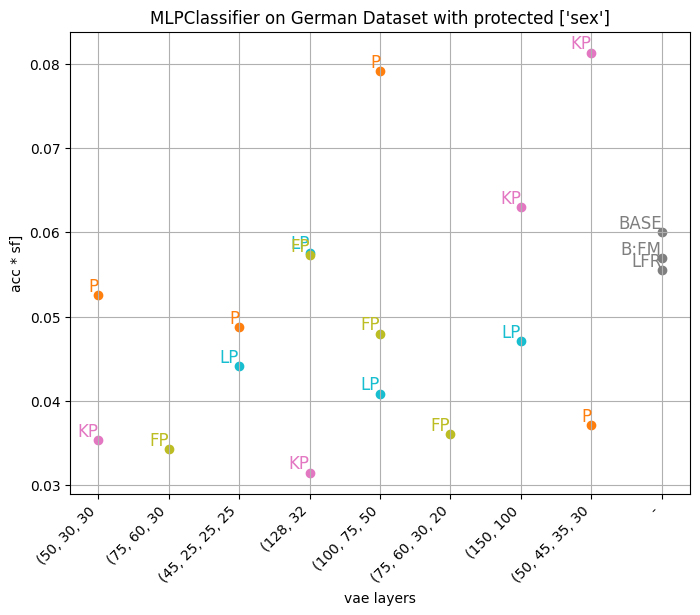

____________________________________________________________________________________________________
German Dataset , LogisticRegression ['sex']


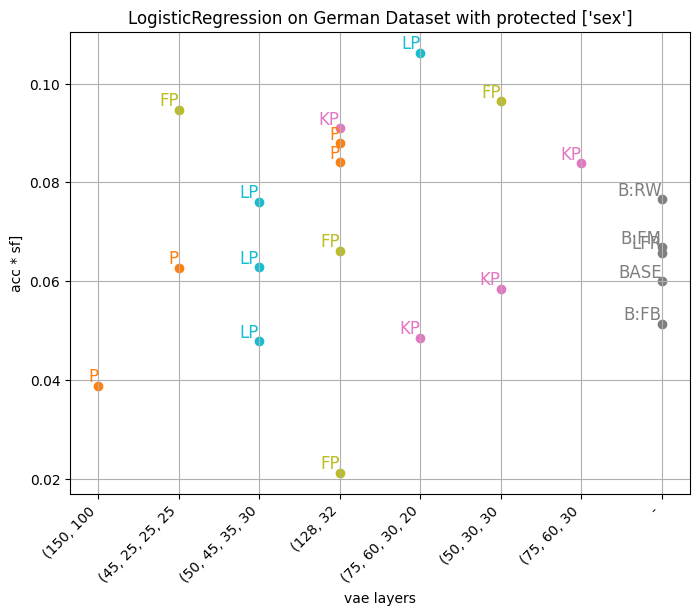

____________________________________________________________________________________________________
Adult Dataset , MLPClassifier ['sex']


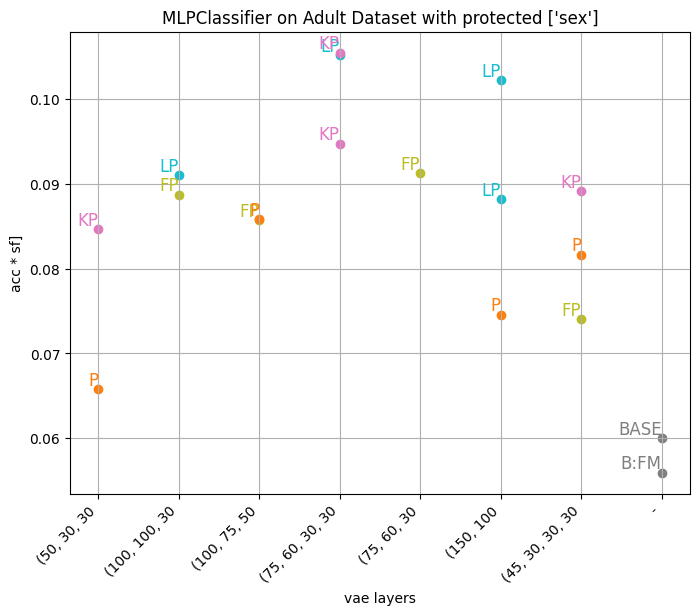

____________________________________________________________________________________________________
Adult Dataset , LogisticRegression ['sex']


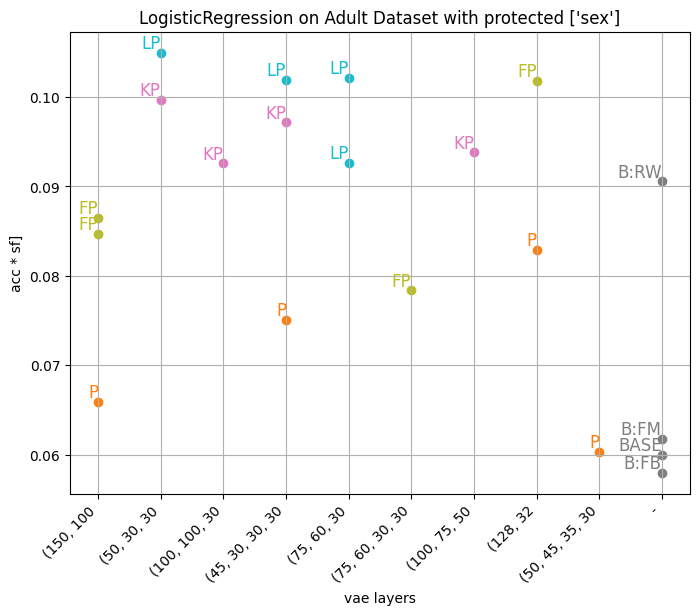

unable to find base for 0 index 0 is out of bounds for axis 0 with size 0
{'c': 'FYP', 'my model config': "VAEMaskConfig(epochs=1052, latent_dim=12, mask_values=None vae_layers=(50, 45, 35, 30), lr=0.011619999999999998, \nlosses_used=['Latent sens ADV loss', 'Pos Y vec loss', 'Reconstruction loss', 'KL divergence loss'])Latent sens ADV loss: {'weight': 0.07150000000000001, 'lr': 0.051500000000000004, 'optimizer': 'Adam', 'layers': (75, 30, 10), 'input_dim': 11}, Pos Y vec loss: {'weight': 1572000.0}, Reconstruction loss: {'weight': 21.6}, KL divergence loss: {'weight': 0.0053}"}
{}
{}
{}
{}
{'c': 'FYP', 'my model config': "VAEMaskConfig(epochs=1491, latent_dim=7, mask_values=None vae_layers=(100, 100, 30), lr=0.01848, \nlosses_used=['Flipped ADV loss', 'Pos Y vec loss', 'Reconstruction loss', 'KL divergence loss'])Flipped ADV loss: {'weight': 0.0054, 'lr': 0.067, 'optimizer': 'Adam', 'layers': (75, 30, 10), 'input_dim': 10, 'sens_col_ids': [7]}, Pos Y vec loss: {'weight': 912000.0}, Re

,index,data,bias mitigation,ML method,sensitive attrs,other,accuracy,precision,recall,sex|[AOD] Average Odds Difference,sex|[EOD] Equal Opportunity Difference,sex|[SPD] Statistical Parity Difference,sex|[DI_FM] Disparate Impact the way it was implemented in FairMask,[SF] Statistical Parity Subgroup Fairness,id,vae layers,acc * sf
0,0,Compas Dataset,FYP VAE,MLPClassifier,['sex'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",0.000000,0.610825,0.654696,-0.050600,-0.044058,0.005017,0.009224,0.000669,-1266841196,"(50, 45, 35, 30",0.058996
1,1,Compas Dataset,Reweighing Bias Mitigation,LogisticRegression,['sex'],{},-0.006954,-0.006128,-0.005525,-0.185211,-0.171043,-0.178875,-0.197814,-0.023864,-1266841196,-,0.093576
2,2,Compas Dataset,FairBalance Bias Mitigation,LogisticRegression,['sex'],{},-0.009736,0.016603,-0.099448,-0.211668,-0.196627,-0.205307,-0.221427,-0.027391,-1266841196,-,0.097806
3,3,Compas Dataset,FairMask Bias Mitigation,LogisticRegression,['sex'],{},-0.005563,-0.000554,-0.022099,-0.107776,-0.101266,-0.105263,-0.101456,-0.014044,-1266841196,-,0.079562
4,4,Compas Dataset,No Bias Mitigation,LogisticRegression,['sex'],{},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1266841196,-,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,596,Compas Dataset,No Bias Mitigation,LogisticRegression,['sex'],{},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1592798727,-,0.060000
407,597,Compas Dataset,FYP VAE,LogisticRegression,['sex'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",-0.134910,-0.132444,0.202532,-0.252549,-0.175595,-0.257674,-0.302487,-0.039297,1592798727,"(100, 100, 30",0.065456
408,598,Compas Dataset,FYP VAE,LogisticRegression,['sex'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",-0.134910,-0.132444,0.202532,-0.252549,-0.175595,-0.257674,-0.302487,-0.039297,1592798727,"(45, 25, 25, 25",0.065456
409,599,Compas Dataset,FYP VAE,LogisticRegression,['sex'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",0.000000,0.015365,-0.045570,-0.349784,-0.350397,-0.348744,-0.126851,-0.025408,1592798727,"(128, 32",0.098112


In [17]:
results_filename = "hyperparams_sex"

results_file = os.path.join("results",results_filename +".csv")
reader = ResultsReader(results_file)

all_metrics = reader.metrics
metrics_to_use = ["SF","acc"]
metrics_to_display = [m for m in all_metrics if metric_has_substring(m, metrics_to_use)] +[OtherColReader.ACC_SF_TO]

for col in ResultsReader.FILTERABLE:
    print(reader.get_all_column_values(col))
    
print(reader.columns_shown)

def f(df):
    mask = (df["accuracy"]> -0.02 ) &(df["[SF] Statistical Parity Subgroup Fairness"]< -0.02 ) |  ~(df["other"].str.contains('FYP')) 
    return df#[mask]
reader.relative_metrics_filter = f

grapher = ResultsGrapher(reader)
grapher.show_legend = False
grapher.plot_metrics_vs_metric(mean=True, relative=True, metrics = metrics_to_display, metric=OtherColReader.VAE_LAYERS)

reader.clear_filters()


relative= reader.get_relative_metrics()

for r in relative['other']:
    print(r)
    
relative


File 'results\hyperparams_race.csv' successfully loaded as DataFrame.
['Compas Dataset', 'Adult Dataset']
['MLPClassifier', 'LogisticRegression']
["['race']"]
['FairMask Bias Mitigation', 'No Bias Mitigation', 'FYP VAE', 'Reweighing Bias Mitigation', 'FairBalance Bias Mitigation', 'LFR']
['{}', '{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1451, latent_dim=12, mask_values=None vae_layers=(100, 75, 50), lr=0.022400000000000003, \\nlosses_used=[\'Flipped ADV loss\', \'Pos Y vec loss\', \'Reconstruction loss\', \'KL divergence loss\'])Flipped ADV loss: {\'weight\': 0.0072, \'lr\': 0.063, \'optimizer\': \'Adam\', \'layers\': (75, 30, 10), \'input_dim\': 10, \'sens_col_ids\': [8]}, Pos Y vec loss: {\'weight\': 1548000.0}, Reconstruction loss: {\'weight\': 20.85}, KL divergence loss: {\'weight\': 0.004}"}', '{\'c\': \'FYP\', \'my model config\': "VAEMaskConfig(epochs=1573, latent_dim=8, mask_values=None vae_layers=(128, 32), lr=0.0049, \\nlosses_used=[\'Sensitive KL loss\', \'

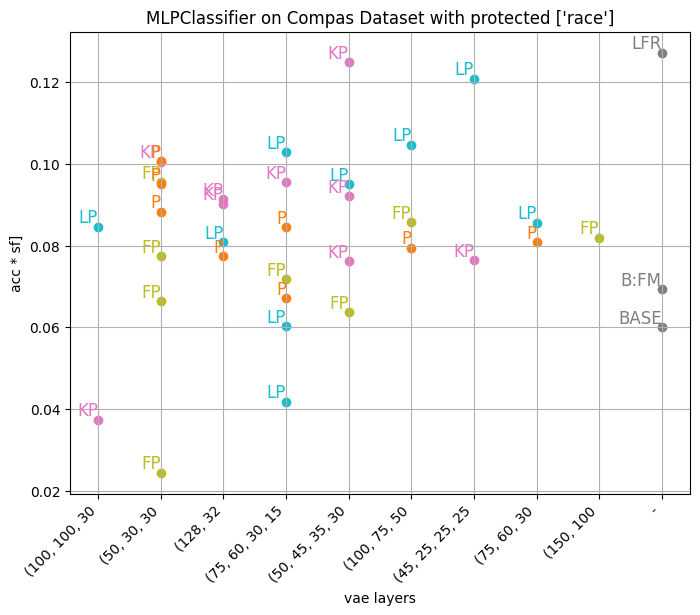

____________________________________________________________________________________________________
Compas Dataset , LogisticRegression ['race']
unable to find base for 120 index 0 is out of bounds for axis 0 with size 0


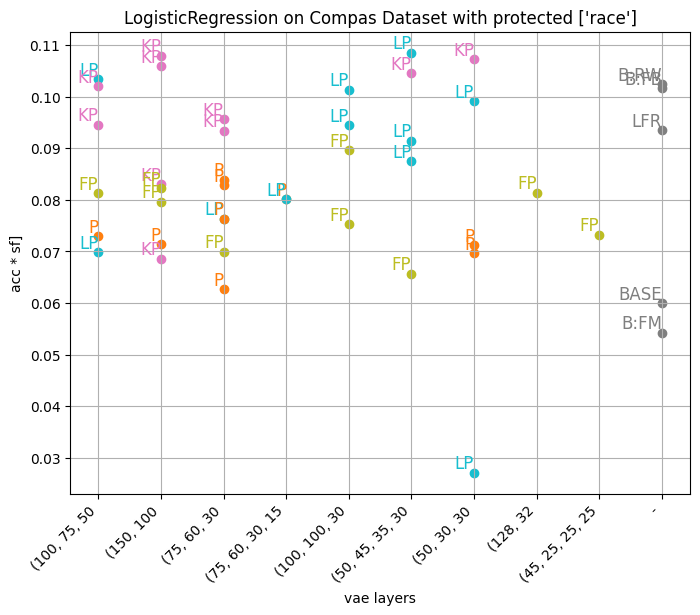

____________________________________________________________________________________________________
Adult Dataset , MLPClassifier ['race']


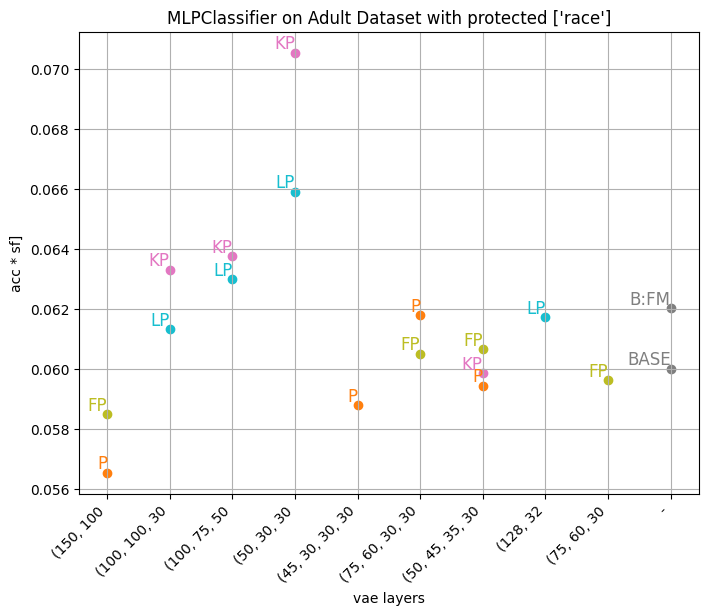

____________________________________________________________________________________________________
Adult Dataset , LogisticRegression ['race']


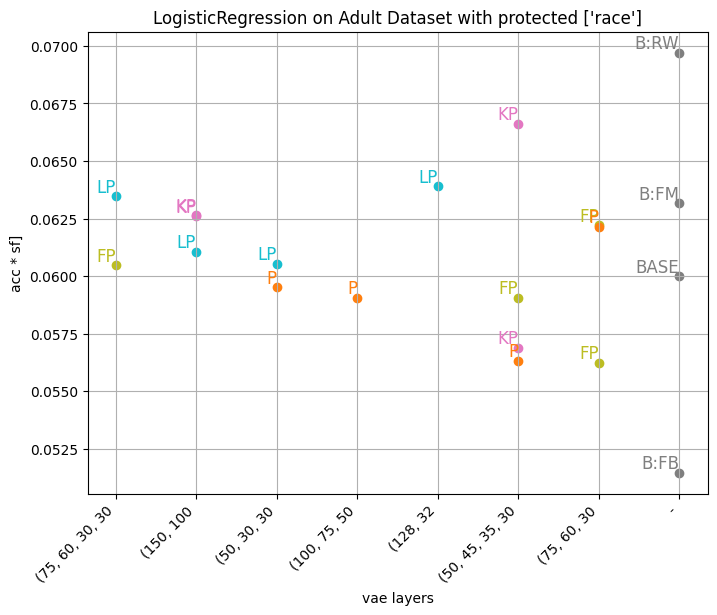

unable to find base for 310 index 0 is out of bounds for axis 0 with size 0
{}
{}
{'c': 'FYP', 'my model config': "VAEMaskConfig(epochs=1451, latent_dim=12, mask_values=None vae_layers=(100, 75, 50), lr=0.022400000000000003, \nlosses_used=['Flipped ADV loss', 'Pos Y vec loss', 'Reconstruction loss', 'KL divergence loss'])Flipped ADV loss: {'weight': 0.0072, 'lr': 0.063, 'optimizer': 'Adam', 'layers': (75, 30, 10), 'input_dim': 10, 'sens_col_ids': [8]}, Pos Y vec loss: {'weight': 1548000.0}, Reconstruction loss: {'weight': 20.85}, KL divergence loss: {'weight': 0.004}"}
{'c': 'FYP', 'my model config': "VAEMaskConfig(epochs=1573, latent_dim=8, mask_values=None vae_layers=(128, 32), lr=0.0049, \nlosses_used=['Sensitive KL loss', 'Pos Y vec loss', 'Reconstruction loss', 'KL divergence loss'])Sensitive KL loss: {'weight': 7380.0, 'sens_col_ids': [8]}, Pos Y vec loss: {'weight': 1152000.0}, Reconstruction loss: {'weight': 16.05}, KL divergence loss: {'weight': 0.00615}"}
{'c': 'FYP', 'my mod

,index,data,bias mitigation,ML method,sensitive attrs,other,accuracy,precision,recall,race|[AOD] Average Odds Difference,race|[EOD] Equal Opportunity Difference,race|[SPD] Statistical Parity Difference,race|[DI_FM] Disparate Impact the way it was implemented in FairMask,[SF] Statistical Parity Subgroup Fairness,id,vae layers,acc * sf
0,14,Compas Dataset,FairMask Bias Mitigation,MLPClassifier,['race'],{},-0.008345,-0.010428,0.002392,-0.012074,0.065789,0.004555,-0.014736,-0.001025,985534569,-,0.059826
1,15,Compas Dataset,No Bias Mitigation,MLPClassifier,['race'],{},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,985534569,-,0.060000
2,16,Compas Dataset,FYP VAE,MLPClassifier,['race'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",0.000000,-0.002685,0.007177,0.080046,0.114662,0.086835,-0.168131,-0.019545,985534569,"(100, 75, 50",0.089317
3,17,Compas Dataset,FYP VAE,MLPClassifier,['race'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",0.008345,0.005130,0.011962,0.110213,0.101504,0.107324,-0.203974,-0.024157,985534569,"(128, 32",0.098912
4,18,Compas Dataset,FYP VAE,MLPClassifier,['race'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",0.013908,0.005136,0.028708,0.102283,0.148496,0.109928,-0.210353,-0.024743,985534569,"(75, 60, 30",0.101616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,501,Compas Dataset,FairBalance Bias Mitigation,LogisticRegression,['race'],{},-0.006954,0.024101,-0.080605,0.144528,0.118426,0.138739,-0.253143,-0.031865,-1886799718,-,0.105299
362,502,Compas Dataset,FairMask Bias Mitigation,LogisticRegression,['race'],{},0.000000,-0.002667,0.007557,-0.024645,-0.018987,-0.023346,0.043492,0.005362,-1886799718,-,0.051957
363,503,Compas Dataset,No Bias Mitigation,LogisticRegression,['race'],{},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1886799718,-,0.060000
364,504,Compas Dataset,FYP VAE,LogisticRegression,['race'],"{'c': 'FYP', 'my model config': ""VAEMaskConfig...",-0.130737,-0.142994,0.241814,0.150640,0.149356,0.183048,-0.341000,-0.042042,-1886799718,"(150, 100",0.069433


In [18]:
results_filename = "hyperparams_race"

results_file = os.path.join("results",results_filename +".csv")
reader = ResultsReader(results_file)

all_metrics = reader.metrics
metrics_to_use = ["SF","acc"]
metrics_to_display = [m for m in all_metrics if metric_has_substring(m, metrics_to_use)] +[OtherColReader.ACC_SF_TO]
metrics_to_display =[OtherColReader.ACC_SF_TO]

for col in ResultsReader.FILTERABLE:
    print(reader.get_all_column_values(col))
    
print(reader.columns_shown)

def f(df):
    mask = (df["accuracy"]> -0.02 ) &(df["[SF] Statistical Parity Subgroup Fairness"]< -0.02 ) |  ~(df["other"].str.contains('FYP')) 
    return df#[mask]
reader.relative_metrics_filter = f

grapher = ResultsGrapher(reader)
grapher.show_legend = False
grapher.plot_metrics_vs_metric(mean=True, relative=True, metrics = metrics_to_display, metric=OtherColReader.VAE_LAYERS)

reader.clear_filters()


relative= reader.get_relative_metrics()

for r in relative['other']:
    print(r)
    
relative
